In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline

import warnings
warnings.filterwarnings('ignore')

# Case 1: Well-separated peaks

## Spectrum

Peak shape in a spectrum can be expressed by Gaussian, Lorentzian, or their convolution (Voigt function). In addition, there are some noises in the spectrum that come from small changes of experimental conditions. In order to take these factors into account, a spectrum is expressed as the sum of random noise and two Gaussian functions with different widths in the present analysis. The spectrum is averaged over `ave_num` times, which corresponds to the situation where you measure spectra several times. The averaged spectrum will be used for analysis. 

At first, we will consider the case in which two peaks are well separated. Below are the figures of the spectrum with random noise and averaged one.

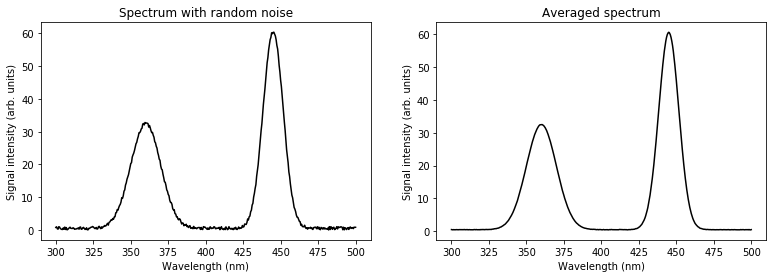

In [2]:
lambda1=445 
lambda2=360 
wid1=90
wid2=200
amp1=60
amp2=32

ave_num=100

x = np.linspace(300,500,401)
y = np.zeros_like(x)

for j in range(x.shape[0]):
    rand_parms=np.random.random()
    y[j] = rand_parms + amp1*np.exp(-(x[j]-lambda1)*(x[j]-lambda1)/wid1) + amp2*np.exp(-(x[j]-lambda2)*(x[j]-lambda2)/wid2)  

plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(x,y,color='k')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal intensity (arb. units)')
plt.title('Spectrum with random noise')

y = np.zeros_like(x) # initialization

for i in range(ave_num):
    for j in range(x.shape[0]):
        rand_parms=np.random.random()
        y[j] = y[j] + rand_parms +  amp1*np.exp(-(x[j]-lambda1)*(x[j]-lambda1)/90) + amp2*np.exp(-(x[j]-lambda2)*(x[j]-lambda2)/200)  

y=y/ave_num
plt.subplot(122)
plt.plot(x,y, color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal intensity (arb. units)')
plt.title('Averaged spectrum')
plt.show()

The averaged spectrum looks neat. However, if you take a look at this spectrum in detail, you can still see small noise.

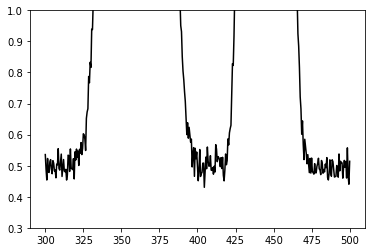

In [3]:
plt.plot(x,y, color='black')
plt.ylim([0.3,1])
plt.show()

## Derivative spectra

In order to get derivative spectra, the function `getDerivative` is defined. Since high-order derivatives are strongly affected by experimental noise, it is important to decrease the it. A smoothing is performed to the spectrum nf + 1 times using [Savitzky-Golay filter](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html), where `nf` is the order of the derivative.

If the length of the filter window, `wf`, is moderately large, it is possible to get a smoother spectrum. However, if this parameter is extremely large, the spectrum will be distorted. In order to check this effect, the function `getDerivative` displays the normalized difference between the raw and smoothed spectra. If this value is too large, you should change the length of the filter window.

In [4]:
def getDerivative(yf,wf,pf,nf):   
# yf: input data. 1D-numpy array
#wf: length of the filter window. Positive integer
#pf: oder of the polynomial used to fit the samples.
#nf: order of the derivative 

    y_temp=yf

    for j in range(nf):
        yf = savgol_filter(yf, window_length = w, polyorder = p, deriv=0) 

    yf_comp = savgol_filter(yf, window_length = w, polyorder = p, deriv=0) 
    dyf = savgol_filter(yf, window_length = w, polyorder = p, deriv=nf) 
    
    diff=np.sum(np.abs(y_temp-yf_comp))/np.max(yf)
    print("Normalized difference between the raw and smoothed spectra:",diff) 
    return dyf # return derivative

Below are raw and smoothed spectra and their first-, second-, third-, and forth-derivative spectra.

Normalized difference between the raw and smoothed spectra: 0.14279114889048644
Normalized difference between the raw and smoothed spectra: 0.15355735976018306
Normalized difference between the raw and smoothed spectra: 0.1635061682546628
Normalized difference between the raw and smoothed spectra: 0.17356634279459696


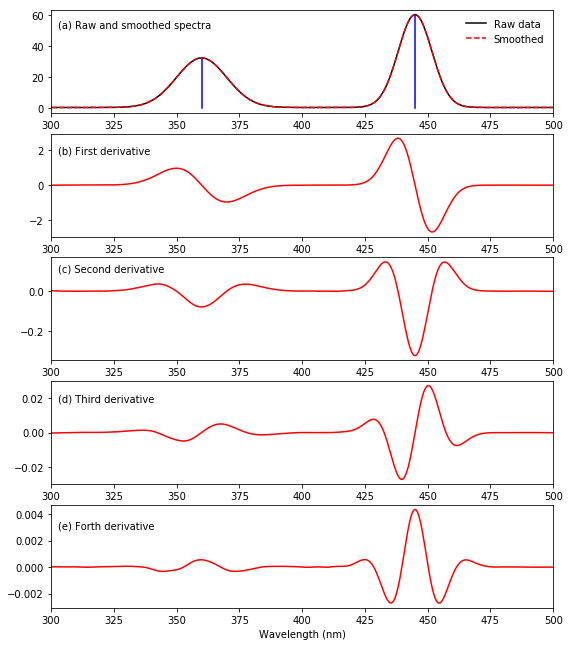

In [5]:
w = 27
p = 4

plt.figure(figsize=(9,11))

plt.subplot(511)
y_smth = savgol_filter(y, window_length = w, polyorder = p, deriv=0)
plt.plot(x,y,color='black',label='Raw data')
plt.plot(x,y_smth, '--',color='red', label='Smoothed')
plt.plot(np.array([lambda1,lambda1]),np.array([0,amp1]),color='blue')
plt.plot(np.array([lambda2,lambda2]),np.array([0,amp2]),color='blue')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y.max()-y.max()/7,'(a) Raw and smoothed spectra')
plt.legend(frameon=False)


# first derivative
plt.subplot(512)
y_smth1 = getDerivative(y,w,p,1)
plt.plot(x,y_smth1, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth1.max()-y_smth1.max()/3,'(b) First derivative')

# second derivative
plt.subplot(513)
y_smth2 = getDerivative(y,w,p,2)
plt.plot(x,y_smth2, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth2.max()-y_smth2.max()/3,'(c) Second derivative')

# third derivative
plt.subplot(514)
y_smth3 = getDerivative(y,w,p,3)
plt.plot(x,y_smth3, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth3.max()-y_smth3.max()/3,'(d) Third derivative')

# fourth derivative
plt.subplot(515)
y_smth4 = getDerivative(y,w,p,4)
plt.plot(x,y_smth4, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth4.max()-y_smth4.max()/3,'(e) Forth derivative')

plt.xlabel('Wavelength (nm)')
plt.show()

- <strong>Figure (b): First derivative.</strong>   
The first-order derivative is 0 if there are no peaks. This derivative shows oscillatory structures around peaks. The most important feature of this derivative is that it passes through 0 at the peaks in the spectrum. 

- <strong>Figure (c): Second derivative.</strong>   
The second-order derivative has minimum at the peak in the spectrum. It also shows additional positive satellie bands at both sides of the minimum. 

- <strong>Figure (e): Forth derivative.</strong>  
The forth-order derivative shows positive peaks whose position is the same as the peaks in the spectrum.

# Case 2: Overlapped peaks

## Spectrum

Next, we will investigate overlapped peaks. In the spectrum shown below, there are 3 peaks. You can clearly see the highest peak and shoulder. The highest peak consists of 2 peaks, which are not visible by eye. The positions and amplitudes of the peaks are shown by a blue stick spectrum.

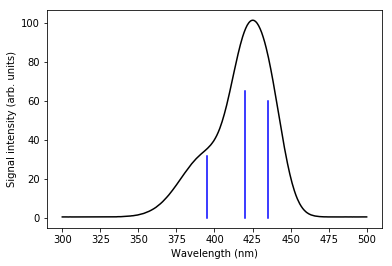

In [6]:
x = np.linspace(300,500,401)
y = np.zeros_like(x)

lambda1=435
lambda2=420
lambda3=395

wid1=200
wid2=200
wid3=600

amp1=60
amp2=65
amp3=32

ave_num=500

for i in range(ave_num):
    for j in range(x.shape[0]):
        rand_parms=np.random.random()
        y[j] = y[j] + rand_parms +  amp1*np.exp(-(x[j]-lambda1)*(x[j]-lambda1)/wid1) + amp2*np.exp(-(x[j]-lambda2)*(x[j]-lambda2)/wid2) + amp3*np.exp(-(x[j]-lambda3)*(x[j]-lambda3)/wid3)   

y=y/ave_num
plt.plot(x,y, color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal intensity (arb. units)')
plt.plot(np.array([lambda1,lambda1]),np.array([0,amp1]),color='blue')
plt.plot(np.array([lambda2,lambda2]),np.array([0,amp2]),color='blue')
plt.plot(np.array([lambda3,lambda3]),np.array([0,amp3]),color='blue')
plt.show()

## Derivative spectra

Below are raw and smoothed spectra and their first-, second-, third-, and forth-derivative spectra.

Normalized difference between the raw and smoothed spectra: 0.03780533427230615
Normalized difference between the raw and smoothed spectra: 0.038355463708763575
Normalized difference between the raw and smoothed spectra: 0.03860183737000009
Normalized difference between the raw and smoothed spectra: 0.03889578878441396


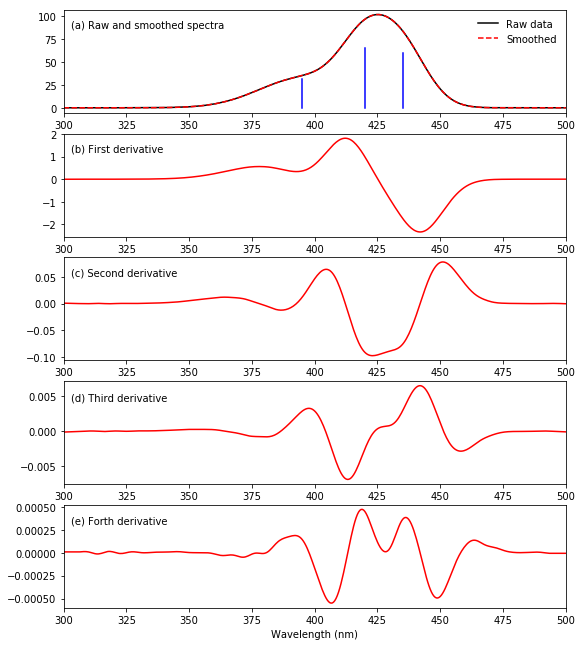

In [7]:
w = 27
p = 4

plt.figure(figsize=(9,11))

plt.subplot(511)
y_smth = savgol_filter(y, window_length = w, polyorder = p, deriv=0)
plt.plot(x,y,color='black',label='Raw data')
plt.plot(x,y_smth, '--',color='red', label='Smoothed')
plt.plot(np.array([lambda1,lambda1]),np.array([0,amp1]),color='blue')
plt.plot(np.array([lambda2,lambda2]),np.array([0,amp2]),color='blue')
plt.plot(np.array([lambda3,lambda3]),np.array([0,amp3]),color='blue')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y.max()-y.max()/7,'(a) Raw and smoothed spectra')
plt.legend(frameon=False)


# first derivative
plt.subplot(512)
y_smth1 = getDerivative(y,w,p,1)
plt.plot(x,y_smth1, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth1.max()-y_smth1.max()/3,'(b) First derivative')

plt.subplot(513)
y_smth2 = getDerivative(y,w,p,2)
plt.plot(x,y_smth2, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth2.max()-y_smth2.max()/3,'(c) Second derivative')

plt.subplot(514)
y_smth3 = getDerivative(y,w,p,3)
plt.plot(x,y_smth3, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth3.max()-y_smth3.max()/3,'(d) Third derivative')

plt.subplot(515)
y_smth4 = getDerivative(y,w,p,4)
plt.plot(x,y_smth4, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth4.max()-y_smth4.max()/3,'(e) Forth derivative')

plt.xlabel('Wavelength (nm)')
plt.show()

The most important result here is that the buried peaks are clearly distinctive in the fourth-order derivative. This is the advantage of the derivative spectroscopy.

# Case 3: Buried peaks

## Spectrum

Sometimes signal peaks are buried in scattering and not visible by eye. In this case, the derivative spectra are helpful to identify peaks buried in a background. 

Here, for the sake of simplicity, random noise is not added. Background signal is expressed by a quadratic function. Buried peak positions are shown by blue lines.

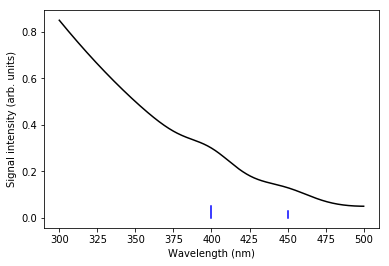

In [123]:
x = np.linspace(300,500,401)
y = np.zeros_like(x)

lambda1=400
lambda2=450

wid1=400
wid2=500

amp1=0.05
amp2=0.03

for j in range(x.shape[0]):
    y[j] = y[j] + rand_parms + amp1*np.exp(-(x[j]-lambda1)*(x[j]-lambda1)/wid1) + amp2*np.exp(-(x[j]-lambda2)*(x[j]-lambda2)/wid2) + (x[j]-500)*(x[j]-500)/50000+0.05

y=y/ave_num
plt.plot(x,y, color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal intensity (arb. units)')
plt.plot(np.array([lambda1,lambda1]),np.array([0,amp1]),color='blue')
plt.plot(np.array([lambda2,lambda2]),np.array([0,amp2]),color='blue')
plt.show()

## Derivative spectra

Normalized difference between the raw and smoothed spectra: 5.789417385031439e-09
Normalized difference between the raw and smoothed spectra: 8.652943990406055e-09
Normalized difference between the raw and smoothed spectra: 1.1512446665898555e-08
Normalized difference between the raw and smoothed spectra: 1.4368842153681317e-08


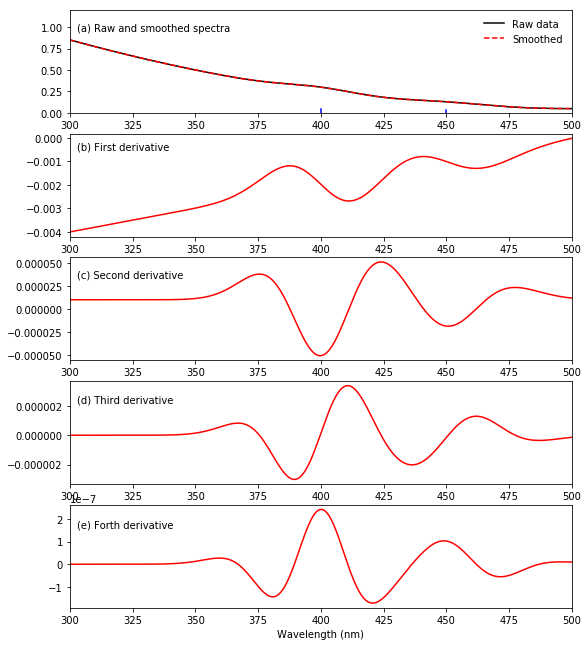

In [148]:
w = 7
p = 4

plt.figure(figsize=(9,11))

plt.subplot(511)
y_smth = savgol_filter(y, window_length = w, polyorder = p, deriv=0)
plt.plot(x,y,color='black',label='Raw data')
plt.plot(x,y_smth, '--',color='red', label='Smoothed')
plt.plot(np.array([lambda1,lambda1]),np.array([0,amp1]),color='blue')
plt.plot(np.array([lambda2,lambda2]),np.array([0,amp2]),color='blue')
plt.xlim([x.min(),x.max()])
plt.ylim([0,1.2])
plt.text(x.min()+3,y.max()+0.1,'(a) Raw and smoothed spectra')
plt.legend(frameon=False)


# first derivative
plt.subplot(512)
y_smth1 = getDerivative(y,w,p,1)
plt.plot(x,y_smth1, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth1.max()-0.0005,'(b) First derivative')

# second derivative
plt.subplot(513)
y_smth2 = getDerivative(y,w,p,2)
plt.plot(x,y_smth2, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth2.max()-y_smth2.max()/3,'(c) Second derivative')

# third derivative
plt.subplot(514)
y_smth3 = getDerivative(y,w,p,3)
plt.plot(x,y_smth3, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth3.max()-y_smth3.max()/3,'(d) Third derivative')

# fourth derivative
plt.subplot(515)
y_smth4 = getDerivative(y,w,p,4)
plt.plot(x,y_smth4, color='red')
plt.xlim([x.min(),x.max()])
plt.text(x.min()+3,y_smth4.max()-y_smth4.max()/3,'(e) Forth derivative')

plt.xlabel('Wavelength (nm)')
plt.show()

The buried peaks are clearly visible, especially in the second- and fourth-order derivatives.